
# MNIST classification with CNN

Inspired by the [CNN MNIST Fidle tutorial](https://fidle.cnrs.fr/w3/)

## 1. Imports

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## 2. Parameters and utils

In [16]:
batch_size = 512
num_epochs = 8
num_images = 72
rng = np.random.default_rng(int(time.time()))

In [30]:
def plot_imgs(images, labels, preds, num_images, cols):
	rows = (num_images + cols - 1) // cols

	fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
	fig.subplots_adjust(hspace=0.5, wspace=0.5)

	# Show the images
	for i in range(num_images):
		ax = axes[i // cols, i % cols]
		ax.imshow(images[i].numpy().squeeze(), cmap='gray')
		if preds == None:
			ax.set_title(labels[i].item(), color='black')
		elif preds[i] == labels[i]:
			ax.set_title(preds[i].item(), color='green')
		else:
			ax.set_title(f'{preds[i].item()} ({labels[i].item()})', color='red')
		ax.axis('off')

	# Fill the empty plots with white images
	for j in range(num_images, rows * cols):
		ax = axes[j // cols, j % cols]
		ax.axis('off')

	plt.show()

## 3. Retrieve and prepare the data

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


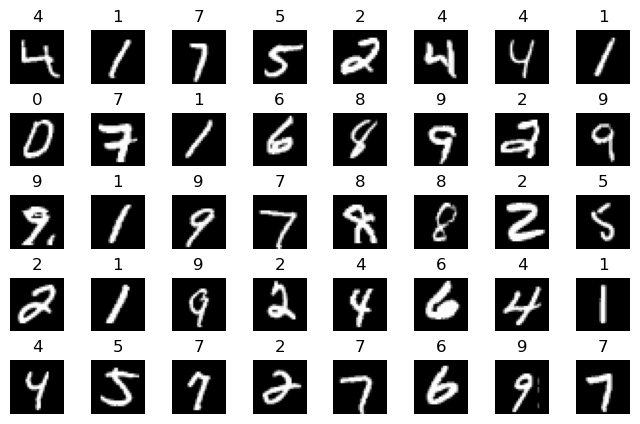

In [18]:
# Load the data
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

trainset = MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=40, shuffle=True)

testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Verify the shape of the data
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape[1:])

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape[1:])

# Print some images
plot_imgs(images, labels, None, 40, 8)

## 3. Create the model

In [19]:
# Define the model
class Model(nn.Module):
	def __init__(self):
		super(Model, self).__init__()

		self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
		self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.dropout1 = nn.Dropout(0.2)

		self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
		self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.dropout2 = nn.Dropout(0.2)

		self.fc1 = nn.Linear(16 * 7 * 7, 100)
		self.dropout3 = nn.Dropout(0.5)
		self.fc2 = nn.Linear(100, 10)

	def forward(self, x):
		x = self.pool1(F.relu(self.conv1(x)))
		x = self.dropout1(x)
		x = self.pool2(F.relu(self.conv2(x)))
		x = self.dropout2(x)
		x = x.view(-1, 16 * 7 * 7) # Flatten
		x = F.relu(self.fc1(x))
		x = self.dropout3(x)
		x = self.fc2(x)
		return x

# Instantiate the model
model = Model()
display(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

## 4. Move the model to the GPU

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


## 5. Train the model

In [21]:
# Create a directory to save the model
os.makedirs('models', mode=0o750, exist_ok=True)
save_path = 'models/mnist_cnn.pth'

best_accuracy = 0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):

	# Train the model
	model.train()
	train_loss = 0
	train_accuracy = 0
	
	for i, data in enumerate(trainloader, 0):
		images, labels = data
		images, labels = images.to(device), labels.to(device) # Move to GPU
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	train_losses.append(train_loss / len(trainloader))
	train_accuracies.append(train_accuracy / len(trainset))

	# Evaluate the model
	model.eval()
	test_loss = 0
	test_accuracy = 0

	with torch.no_grad():
		for i, data in enumerate(testloader, 0):
			images, labels = data
			images, labels = images.to(device), labels.to(device) # Move to GPU
			outputs = model(images)
			loss = criterion(outputs, labels)
			test_loss += loss.item()
			test_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	test_losses.append(test_loss / len(testloader))
	test_accuracies.append(test_accuracy / len(testset))
	print(f'Epoch {epoch + 1}/{num_epochs}:\tLoss: {test_losses[-1]:.4f},\tAccuracy: {test_accuracies[-1]:.4f}')

	# Save the model if the accuracy is better
	if test_accuracies[-1] > best_accuracy:
		best_accuracy = test_accuracies[-1]
		torch.save(model.state_dict(), save_path)

Epoch 1/8:	Loss: 0.0939,	Accuracy: 0.9698
Epoch 2/8:	Loss: 0.0663,	Accuracy: 0.9794
Epoch 3/8:	Loss: 0.0510,	Accuracy: 0.9838
Epoch 4/8:	Loss: 0.0439,	Accuracy: 0.9851
Epoch 5/8:	Loss: 0.0401,	Accuracy: 0.9867
Epoch 6/8:	Loss: 0.0382,	Accuracy: 0.9861
Epoch 7/8:	Loss: 0.0393,	Accuracy: 0.9872
Epoch 8/8:	Loss: 0.0379,	Accuracy: 0.9867


## 6. Evaluate

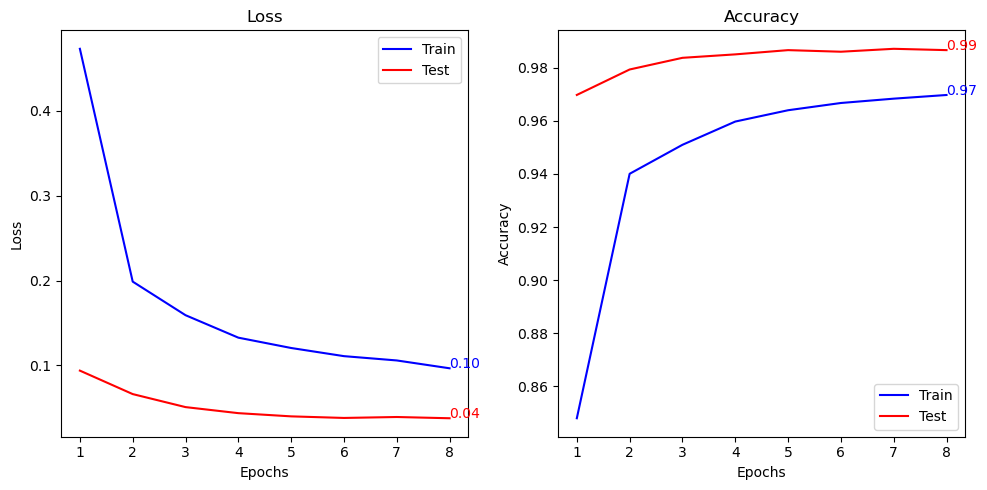

In [26]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train')
plt.plot(epochs, test_losses, 'r', label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(
	f'{train_losses[-1]:.2f}',
	xy         = (epochs[-1], train_losses[-1]),
	xytext     = (epochs[-1], train_losses[-1]),
	color      = 'b',
	arrowprops = None
)
plt.annotate(
	f'{test_losses[-1]:.2f}',
	xy         = (epochs[-1], test_losses[-1]),
	xytext     = (epochs[-1], test_losses[-1]),
	color      = 'r',
	arrowprops = None
)

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train')
plt.plot(epochs, test_accuracies, 'r', label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(
	f'{train_accuracies[-1]:.2f}',
	xy         = (epochs[-1], train_accuracies[-1]),
	xytext     = (epochs[-1], train_accuracies[-1]),
	color      = 'b',
	arrowprops = None
)
plt.annotate(
	f'{test_accuracies[-1]:.2f}',
	xy         = (epochs[-1], test_accuracies[-1]),
	xytext     = (epochs[-1], test_accuracies[-1]),
	color      = 'r',
	arrowprops = None
)

plt.tight_layout()
plt.show()

## 7. Restore the model

In [23]:
model_path = 'models/mnist_cnn.pth'
model = Model()
model.load_state_dict(torch.load(model_path, weights_only=True))
display(model)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

## 8. Make predictions

In [24]:
# Make predictions
all_images = []
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
	for images, labels in testloader:
		outputs = model(images)
		y_sigmoid = torch.nn.functional.softmax(outputs, dim=1)
		y_pred = torch.argmax(y_sigmoid, dim=1)
		
		all_images.append(images.cpu())
		all_labels.append(labels.cpu())
		all_preds.append(y_pred.cpu())

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_preds = torch.cat(all_preds, dim=0)

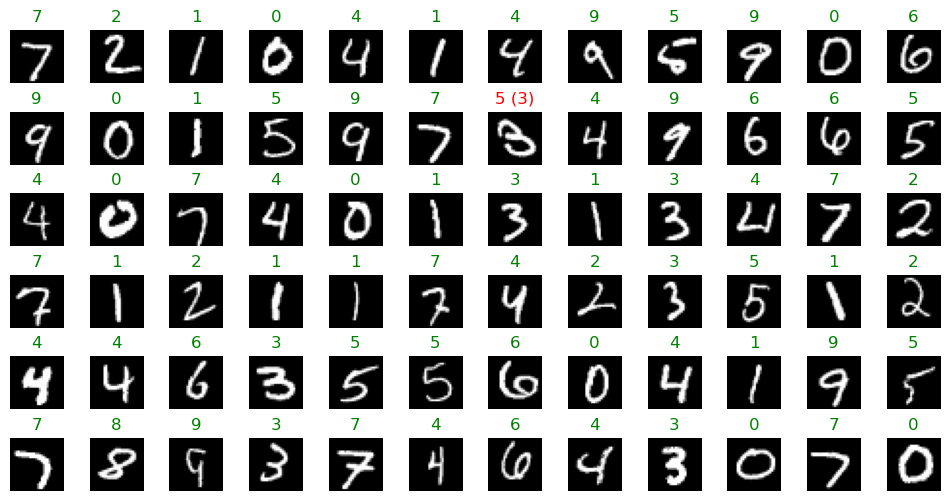

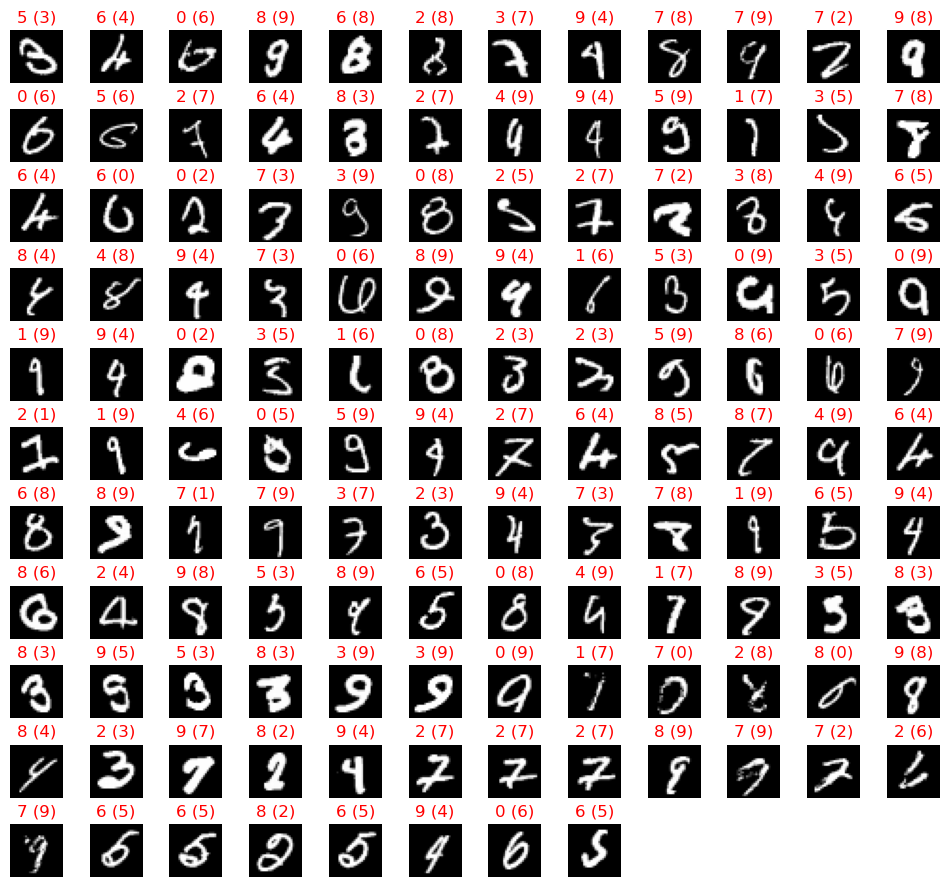

In [32]:
# Print some results
indice = rng.integers(0, len(all_images) - 16)
plot_imgs(all_images, all_labels, all_preds, num_images, 12)

# Print all errors
errors = all_preds != all_labels
error_indices = torch.arange(len(all_preds))[errors]
errors_images = all_images[error_indices]
errors_labels = all_labels[error_indices]
errors_preds = all_preds[error_indices]

plot_imgs(errors_images, errors_labels, errors_preds, len(errors_images), 12)